# Redes Neurais Convolucionais - Revisão

* A diferença está no pré-processamento.
* Varia os kernels para achar o que entrega as características mais relevantes.

## Operação de Convolução

* É o processo de adicionar cada elemento da imagem com seus vizinhos, poderado por um *kernel* (detector de características).
* Ver o link: https://setosa.io/ev/image-kernels/
1. Multiplica matrix da imagem pelo kernel
    * Reduz a dimensão da imagem, algumas informação pode ser perdida
    * Gera uma matriz de características, resaltando as características principais
2. Com o mapa de características (pode ser muitas matrizes), aplica-se a função ReLU para zerar valores negativos, isso facilita a detecção de características.

## Pooling 

* Etapa que realça as características do que está sendo treinado.
* Existe o max pulling, que pega um grupo de pixels e realça o maior valor
    * Reduz ainda mais a dimensão da imagem, realçando as características principais.
    * Auxilia a reduzir o overfitting e ruídos desnecessários
* Existe também o min pulling, e o valor médio do pulling.


## Flattening

* Transforma o formato de matriz (após o pooling) em formato de vetor para que seja processado por uma rede neural.


## Rede Neural Densa

* Análoga ao uso para classificação ou regressão. Vai tentar otimizar os valores dos pesos de cada input para que a saída seja a correta.


# Imports

In [96]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.api.datasets import mnist
from keras.api.models import Sequential
from keras.api.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.api.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import StratifiedKFold

# Importando o dataset e tratando os dados

In [5]:
X_train: np.ndarray
y_train: np.ndarray
X_test: np.ndarray
y_test: np.ndarray

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
# 60000 imagens de 28x28 with greyscale
X_train.shape

(60000, 28, 28)

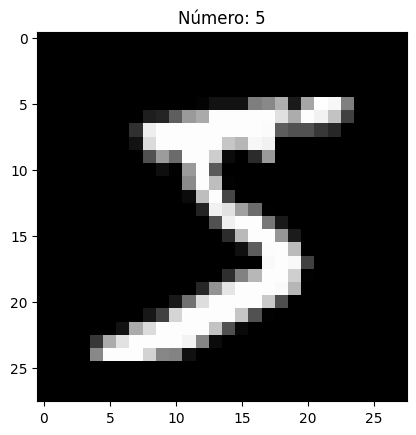

In [18]:
index = 0

plt.imshow(X_train[index], cmap='gray')
plt.title(f'Número: {y_train[index]}')

plt.show()

In [28]:
# precisa redimensionar a imagem para que seja possível a interpretação pelo tensorflow
qntd_registros_imagem = X_train.shape[0]
altura_imagem = 28
largura_imagem = 28
canais_imagem = 1 # Escala de cinza

entradas_treinamento = X_train.reshape(
    qntd_registros_imagem, altura_imagem, largura_imagem, canais_imagem
)
entradas_treinamento = entradas_treinamento.astype('float32') # Precisa ser float para escalar os valores entre 0 e 1
entradas_treinamento = entradas_treinamento / 255

qntd_registros_imagem = X_test.shape[0]
entradas_teste = X_test.reshape(
    qntd_registros_imagem, altura_imagem, largura_imagem, canais_imagem
)
entradas_teste = entradas_teste.astype('float32') # Precisa ser float para escalar os valores entre 0 e 1
entradas_teste = entradas_teste / 255

# Representar as saidas no formato one hot key (Números de 0 a 9)
saida_treinamento = to_categorical(y_train, 10)
saida_teste = to_categorical(y_test, 10)


# Estrutura da Rede Neural Convulocional

In [45]:
def criar_modelo() -> Sequential:
    modelo = Sequential(
        name="MNIST",
        layers=[
            Input(
                shape=entradas_treinamento.shape[1:] # 28 x 28 x 1
            )
        ]
    )
    # 1ª Etapa - Operador de convolução
    modelo.add(
        Conv2D(
            filters= 32, # Número de dectores de características. Ideal é começar com 64 kernels e ir aumentando seguindo base 2.
            kernel_size=(3, 3), # Pensando em compatibilidade com 28x28, já que é imagem pequena. Imagens maiores usar kernel maiores.
            # strides=?, # Movimenta 1 pixel para direita e 1 pixel para baixo respectivamente
            activation='relu' # ativação recomendada para aplicações com imagem
        )
    )
    # 2ª Etapa - Operador Pooling
    modelo.add(
        MaxPooling2D(
            pool_size=(2, 2) # Janela que seleciona os dados dentro do mapa de características (resultado convolução)
        )
    )
    # 3ª Etapa - Operador Flatten
    modelo.add(
        Flatten()
    )
    # 4ª Etapa - Rede Neural Densa
    modelo.add(
        Dense(
            units=128, # Usando a formula resulta em 90... Mas em CNN não é comum seguir essa idea, utiliza 128, 256...
            activation='relu',
        )
    )
    modelo.add(
        Dense(
            units=10,
            activation='softmax'
        )
    )

    modelo.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return modelo


In [46]:
modelo = criar_modelo()

In [47]:
resultados = modelo.fit(
    x=entradas_treinamento,
    y=saida_treinamento,
    batch_size=128,
    epochs=5,
    validation_data=(entradas_teste, saida_teste) # Vai fazer o treinamento e teste diretamente
)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8761 - loss: 0.4425 - val_accuracy: 0.9738 - val_loss: 0.0809
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9787 - loss: 0.0726 - val_accuracy: 0.9810 - val_loss: 0.0568
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9866 - loss: 0.0458 - val_accuracy: 0.9846 - val_loss: 0.0452
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9900 - loss: 0.0332 - val_accuracy: 0.9867 - val_loss: 0.0412
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9931 - loss: 0.0235 - val_accuracy: 0.9838 - val_loss: 0.0466


In [50]:
resultados.history

{'accuracy': [0.9377666711807251,
  0.9800000190734863,
  0.98621666431427,
  0.9895333051681519,
  0.9927666783332825],
 'loss': [0.2171725481748581,
  0.06812582165002823,
  0.04553151875734329,
  0.034790653735399246,
  0.02387120947241783],
 'val_accuracy': [0.973800003528595,
  0.9810000061988831,
  0.9846000075340271,
  0.9866999983787537,
  0.9837999939918518],
 'val_loss': [0.08092563599348068,
  0.05684443190693855,
  0.045161835849285126,
  0.041184455156326294,
  0.04659879580140114]}

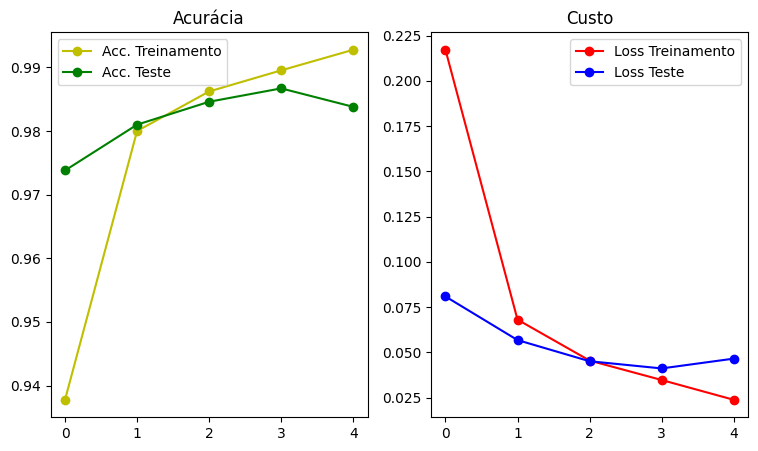

In [69]:
history = resultados.history

fig, (ax1, ax2) = plt.subplots(
    figsize=(9, 5),
    nrows=1,
    ncols=2
)

ax1.set_title("Acurácia")
ax1.plot(history['accuracy'], 'yo-', label="Acc. Treinamento")
ax1.plot(history['val_accuracy'], 'go-', label="Acc. Teste")
ax1.legend()

ax2.set_title("Custo")
ax2.plot(history['loss'], 'ro-', label="Loss Treinamento")
ax2.plot(history['val_loss'], 'bo-', label="Loss Teste")
ax2.legend()

plt.show()

In [70]:
avaliacao = modelo.evaluate(
    x=entradas_teste,
    y=saida_teste
)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9790 - loss: 0.0572


# Melhorias nessa rede para essa base da dados

In [74]:
def criar_modelo_melhorado() -> Sequential:
    modelo = Sequential(
        name="MNIST",
        layers=[
            Input(
                shape=entradas_treinamento.shape[1:] # 28 x 28 x 1
            )
        ]
    )

    # 1ª Etapa - Operador de convolução
    modelo.add(
        Conv2D(
            filters= 32, # Número de dectores de características. Ideal é começar com 64 kernels e ir aumentando seguindo base 2.
            kernel_size=(3, 3), # Pensando em compatibilidade com 28x28, já que é imagem pequena. Imagens maiores usar kernel maiores.
            # strides=(1,1), # Movimenta 1 pixel para direita e 1 pixel para baixo respectivamente
            activation='relu' # ativação recomendada para aplicações com imagem
        )
    )
    ## Melhora 1 -> Aplica-se BatchNormalization em cima da camada de convolução para que normalize os seus resultados e acelere o tempo de treinamento
    modelo.add(
        BatchNormalization()
    )
    # 2ª Etapa - Operador Pooling
    modelo.add(
        MaxPooling2D(
            pool_size=(2, 2) # Janela que seleciona os dados dentro do mapa de características (resultado convolução)
        )
    )

    ## Melhora 2 -> Aplica-se mais uma camada de convolução.
    modelo.add(
        Conv2D(
            filters= 32, # Número de dectores de características. Ideal é começar com 64 kernels e ir aumentando seguindo base 2.
            kernel_size=(3, 3), # Pensando em compatibilidade com 28x28, já que é imagem pequena. Imagens maiores usar kernel maiores.
            # strides=(1,1), # Movimenta 1 pixel para direita e 1 pixel para baixo respectivamente
            activation='relu' # ativação recomendada para aplicações com imagem
        )
    )
    modelo.add(
        BatchNormalization()
    )
    modelo.add(
        MaxPooling2D(
            pool_size=(2, 2) # Janela que seleciona os dados dentro do mapa de características (resultado convolução)
        )
    )

    # 3ª Etapa - Operador Flatten
    ## OBS: Quando possui mais de uma camada de convolução, o flatten vai apenas na última camada
    modelo.add(
        Flatten()
    )

    # 4ª Etapa - Rede Neural Densa
    modelo.add(
        Dense(
            units=128, # Usando a formula resulta em 90... Mas em CNN não é comum seguir essa idea, utiliza 128, 256...
            activation='relu',
        )
    )
    ## Melhoria 3 - Adição do Dropout para evitar o overfitting
    modelo.add(
        Dropout(rate=0.2)
    )

    ## Melhoria 4 - Adição de mais uma camada oculta
    modelo.add(
        Dense(
            units=128, # Usando a formula resulta em 90... Mas em CNN não é comum seguir essa idea, utiliza 128, 256...
            activation='relu',
        )
    )
    modelo.add(
        Dropout(rate=0.2)
    )

    modelo.add(
        Dense(
            units=10,
            activation='softmax'
        )
    )

    modelo.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return modelo


In [75]:
modelo_melhorado = criar_modelo_melhorado()

In [76]:
resultados_modelo_2 = modelo_melhorado.fit(
    x=entradas_treinamento,
    y=saida_treinamento,
    batch_size=128,
    epochs=5,
    validation_data=(entradas_teste, saida_teste) # Vai fazer o treinamento e teste diretamente
)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.8522 - loss: 0.4652 - val_accuracy: 0.9516 - val_loss: 0.1654
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9802 - loss: 0.0672 - val_accuracy: 0.9865 - val_loss: 0.0429
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9864 - loss: 0.0451 - val_accuracy: 0.9867 - val_loss: 0.0422
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9898 - loss: 0.0340 - val_accuracy: 0.9841 - val_loss: 0.0573
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9902 - loss: 0.0300 - val_accuracy: 0.9858 - val_loss: 0.0477


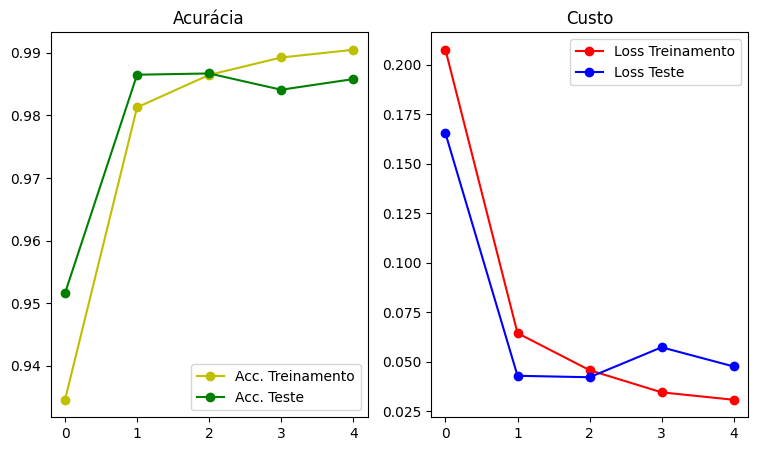

In [77]:
history_2 = resultados_modelo_2.history

fig, (ax1, ax2) = plt.subplots(
    figsize=(9, 5),
    nrows=1,
    ncols=2
)

ax1.set_title("Acurácia")
ax1.plot(history_2['accuracy'], 'yo-', label="Acc. Treinamento")
ax1.plot(history_2['val_accuracy'], 'go-', label="Acc. Teste")
ax1.legend()

ax2.set_title("Custo")
ax2.plot(history_2['loss'], 'ro-', label="Loss Treinamento")
ax2.plot(history_2['val_loss'], 'bo-', label="Loss Teste")
ax2.legend()

plt.show()

# Aplicando a Validação Cruzada

In [80]:
seed = 5
np.random.seed(seed=seed)

k_fold = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=seed
)

resultados = []

In [81]:
# Essa variável serve apenas para gerar os indices para o teste, por conta das saidas estarem no formato 60000x10.
auxiliar = np.zeros(
    shape= (saida_treinamento.shape[0], 1)
)

resultados = []

# Separa a base de dados de treinamento em grupos de teste e treinamento. Nesse caso n_splits=5.
## É feita a interação por cada grupo para achar valores mais precisos e reais de pesos para a rede.
for indice_treinamento, indice_teste in k_fold.split(entradas_treinamento, auxiliar):
    classificador = criar_modelo()
    classificador.fit(
        x=entradas_treinamento[indice_treinamento],
        y=saida_treinamento[indice_treinamento],
        batch_size=128,
        epochs=5,
    )

    precisao = classificador.evaluate(
        x=entradas_treinamento[indice_teste],
        y=saida_treinamento[indice_teste]
    )

    resultados.append(precisao)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8478 - loss: 0.5177
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9732 - loss: 0.0899
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9849 - loss: 0.0532
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9890 - loss: 0.0393
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9915 - loss: 0.0296
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9839 - loss: 0.0566
Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8521 - loss: 0.5104
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9764 - loss: 0.0827
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9854 - loss: 0.0495
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9888 - loss: 0.0381
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9921 - loss: 0.0270
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9833 - los

Custo médio:  0.0540033757686615
Acurácia médio:  0.9839333415031433


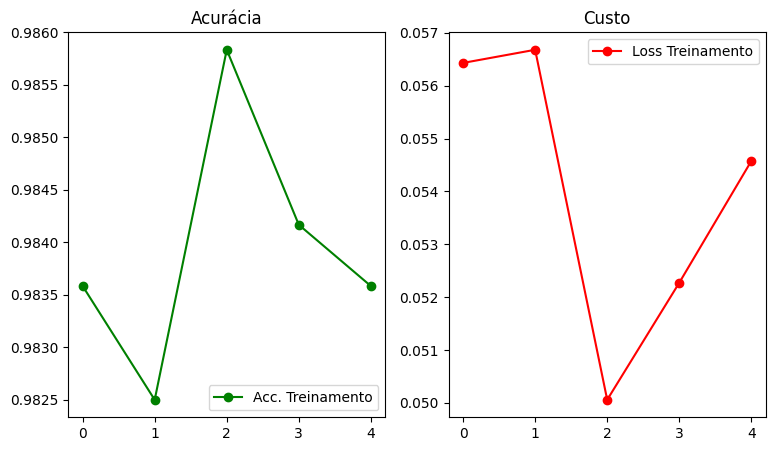

In [91]:
resultados = np.array(resultados)
custo = resultados[:, 0]
acuracia = resultados[:, 1]

print("Custo médio: ", custo.mean())
print("Acurácia médio: ", acuracia.mean())

fig, (ax1, ax2) = plt.subplots(
    figsize=(9, 5),
    nrows=1,
    ncols=2
)

ax1.set_title("Acurácia")
ax1.plot(acuracia, 'go-', label="Acc. Treinamento")
ax1.legend()

ax2.set_title("Custo")
ax2.plot(custo, 'ro-', label="Loss Treinamento")
ax2.legend()

plt.show()

# Técnica de 'Augmentation'

* Muda-se características da imagem para gerar novas, como rotação e direção dos pixes, para aumentar a base de dados

In [101]:
samples = entradas_treinamento.shape[0]
batch_size = 128

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
gerador_treinamento = ImageDataGenerator(
    rotation_range = 7,
    horizontal_flip = True,
    shear_range = 0.2, # Alteração do valor dos pixels. Muda a "direção" do pixel
    height_shift_range = 0.07, # Modifica a altura da imagem
    zoom_range = 0.2 # Altera o zoom da imagem
)
gerador_teste = ImageDataGenerator()

base_treinamento = gerador_treinamento.flow(
    entradas_treinamento,
    saida_treinamento,
    batch_size = batch_size
)

base_teste = gerador_teste.flow(
    entradas_teste,
    saida_teste,
    batch_size = batch_size
)

In [102]:
modelo = criar_modelo()
modelo.fit(
    x = base_treinamento,
    steps_per_epoch = int(samples / batch_size),
    epochs = 5,
    validation_data = base_teste,
    validation_steps = int(samples / batch_size),
)

Epoch 1/5
  1/468 ━━━━━━━━━━━━━━━━━━━━ 6:42 863ms/step - accuracy: 0.0938 - loss: 2.3120

c:\Users\joao.turra\Documents\Git\machine-learning\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


468/468 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.7547 - loss: 0.7919 - val_accuracy: 0.9424 - val_loss: 0.1825
Epoch 2/5
  1/468 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9531 - loss: 0.2647

C:\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9531 - loss: 0.2647 - val_accuracy: 0.9434 - val_loss: 0.1797
Epoch 3/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.9253 - loss: 0.2462 - val_accuracy: 0.9531 - val_loss: 0.1456
Epoch 4/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9297 - loss: 0.1977 - val_accuracy: 0.9550 - val_loss: 0.1407
Epoch 5/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.9440 - loss: 0.1814 - val_accuracy: 0.9689 - val_loss: 0.0979


In [103]:
modelo_melhorado = criar_modelo_melhorado()
modelo_melhorado.fit(
    x = base_treinamento,
    steps_per_epoch = int(samples / batch_size),
    epochs = 5,
    validation_data = base_teste,
    validation_steps = int(samples / batch_size),
)

Epoch 1/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.7520 - loss: 0.7616 - val_accuracy: 0.9382 - val_loss: 0.2072
Epoch 2/5
  1/468 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.9531 - loss: 0.1840

C:\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9531 - loss: 0.1840 - val_accuracy: 0.9371 - val_loss: 0.2104
Epoch 3/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.9431 - loss: 0.1885 - val_accuracy: 0.9389 - val_loss: 0.1982
Epoch 4/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9453 - loss: 0.2099 - val_accuracy: 0.9501 - val_loss: 0.1575
Epoch 5/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.9576 - loss: 0.1366 - val_accuracy: 0.9796 - val_loss: 0.0657


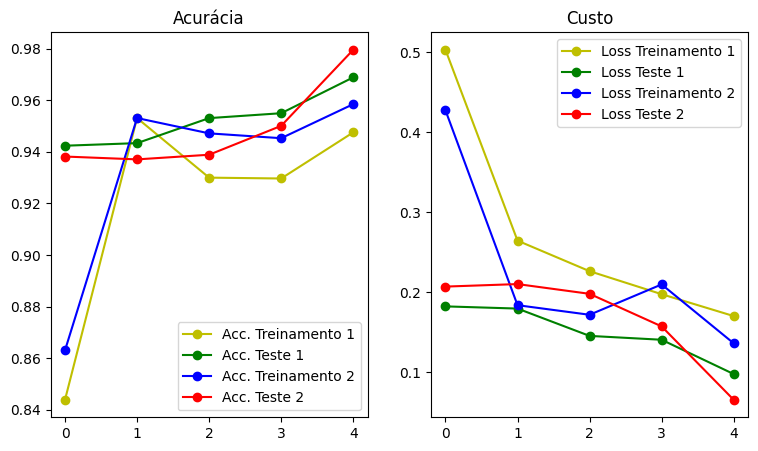

In [108]:
resultados = modelo.history.history
resultados_modelo_2 = modelo_melhorado.history.history

fig, (ax1, ax2) = plt.subplots(
    figsize=(9, 5),
    nrows=1,
    ncols=2
)

ax1.set_title("Acurácia")
ax1.plot(resultados['accuracy'], 'yo-', label="Acc. Treinamento 1")
ax1.plot(resultados['val_accuracy'], 'go-', label="Acc. Teste 1")
ax1.plot(resultados_modelo_2['accuracy'], 'bo-', label="Acc. Treinamento 2")
ax1.plot(resultados_modelo_2['val_accuracy'], 'ro-', label="Acc. Teste 2")
ax1.legend()

ax2.set_title("Custo")
ax2.plot(resultados['loss'], 'yo-', label="Loss Treinamento 1")
ax2.plot(resultados['val_loss'], 'go-', label="Loss Teste 1")
ax2.plot(resultados_modelo_2['loss'], 'bo-', label="Loss Treinamento 2")
ax2.plot(resultados_modelo_2['val_loss'], 'ro-', label="Loss Teste 2")
ax2.legend()

plt.show()